# Employee Retention 
Employee churn is a major cost driver at many companies, as the cost of re-hiring and training a new employee can in many cases be higher than the employee's annual salary. Thus, if employee churn can be predicted, companies can either a) better budget for re-hiring expenses and/or b) reduce the impact of the factors that make an employee leave their job.

In this project we are presented with some limited data on employees from several companies. The data include information about the employee's tenure at the company (hire date and leave date), position, salary, and years of experience prior to being hired at the company. The data span the years 2011-2015. 

Key questions to answer are:
* What are some key individual factors that influence employee churn? For example, salary, discipline, and experience may all play a role in whether or not a company retains an employee. 
* Do company-wide factors play a role in employee churn? For example, perhaps employees at large companies are more likely to leave and pursue other opportunies (or vice versa).
* When does churn occur? Do most dissatisfied employees leave early or do they try and stick around for a few years?

This notebook is organized as follows:
1. Data cleaning and exploration
2. Analysis
3. Conclusion

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
sns.set_style("darkgrid")
from lifelines.utils import datetimes_to_durations
from lifelines.utils import survival_table_from_events
import matplotlib.cm as cm

# 1. Data Cleaning and Exploration

First, we can read in the data and do a quick visual check to assess the cleanliness of the data. We can immediately see that join date has some non-uniform formatting, and that we may want to exclude temp_contractors from our analysis as they are short-term employees where churn is necessarily important to consider. 

In [2]:
employee_data = pd.read_csv('employee_retention.csv', index_col=0)
employee_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


Looking at the column-wise statistics, it is also apparent that there are a few other strange values hidden in the data - for example, the maximum seniority is 99 and the temp contractors drag the average salary down.

In [3]:
employee_data.describe()

,employee_id,company_id,seniority,salary
count,3.470200e+04,34702.000000,34702.000000,34463.000000
mean,6.466667e+05,4.023370,10.056625,100280.585004
std,3.337653e+05,2.911201,9.355505,87322.502536
min,3.600000e+01,1.000000,0.000000,5000.000000
25%,3.529228e+05,1.000000,0.000000,9302.000000
50%,7.063230e+05,3.000000,8.000000,88000.000000
75%,1.001324e+06,6.000000,18.000000,158000.000000
max,1.009999e+06,12.000000,99.000000,408000.000000


We can also look for missing data. As expected there are many missing quit_dates (since some employees never left during the data collection period), but there are also a few missing salaries. We can safely remove these after double checking that they don't have anything in common. 

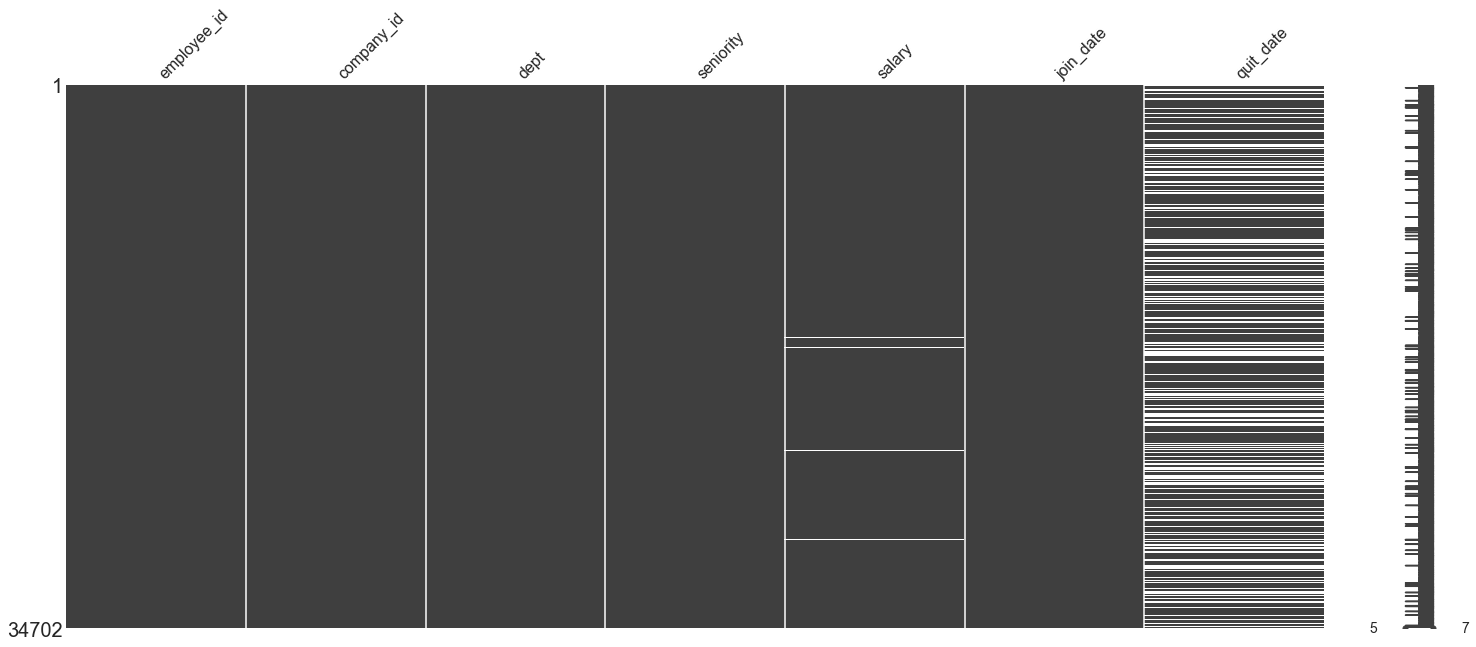

In [4]:
msno.matrix(employee_data)

As a final exploration of the data quality, we can do a series of sanity checks, e.g., making sure that the number of departments is as expected, and then implement the value exclusion and date formatting as described above. 

In [30]:
# sanity checks on the data
print(employee_data['dept'].unique())
# this all seems to be in order - maybe make a distribution to see how things look

# drop salaries that are missing (just a few) and also drop the impossibly high seniorities. 
employee_data = employee_data[employee_data['seniority'] < 95]
employee_data = employee_data.dropna(subset=['salary'])

['temp_contractor' 'design' 'engineer' 'marketing' 'customer_service'
 'data_science' 'sales']


In [6]:
# fix the datetimes - recast the 05.08.2014 etc as standard 2014-08-05
employee_data['join_date'] = employee_data['join_date'].str.replace('.', '-')
employee_data['join_date'] = pd.to_datetime(employee_data['join_date'])

employee_data['quit_date'] = employee_data['quit_date'].str.replace('.', '-')
employee_data['quit_date'] = pd.to_datetime(employee_data['quit_date'])

It is also apparent that the data span a larger date range than expected based on the documentation - digging a little further reveals that these early dates are due to the presence of temporary contractors. We can safely remove these rows. 

In [31]:
print('minimum date', employee_data['join_date'].min())
print('maximum date', employee_data['join_date'].max())

minimum date 2007-01-01 00:00:00
maximum date 2015-12-10 00:00:00


In [8]:
employee_cleaned = employee_data[employee_data['join_date']>=pd.to_datetime('2011/01/04')]
employee_cleaned = employee_cleaned[employee_cleaned['join_date']<=pd.to_datetime('2015/12/23')]
employee_cleaned = employee_cleaned[employee_cleaned['dept']!='temp_contractor']

# 2. Analysis

### When do employees leave?

With our data cleaned, we can now turn our attention to the questions posed in the introduction. First, we can examine the start and exit dates as a function of time. 

We can see that while hiring is approximately constant across the date range, the number of departures per year increases over time. These two patterns do make qualitative sense - even under a simple model where a constant fraction of employees leave per year, as the number of total employees increases (due to constant hiring), the number of employees who leave each year will also increase. 

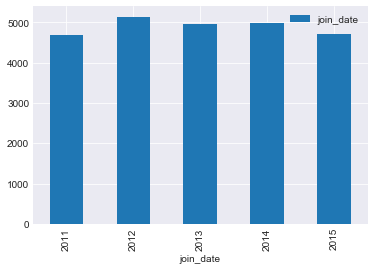

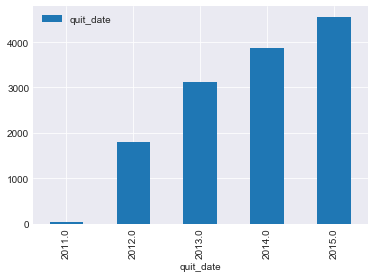

In [9]:
employee_cleaned[['join_date']].groupby(employee_cleaned["join_date"].dt.year).count().plot(kind="bar")
employee_cleaned[['quit_date']].groupby(employee_cleaned["quit_date"].dt.year).count().plot(kind="bar")

From the data exploration, we know that the companies have different sizes, so we can take a look at the exact sizes of the companies. 

Company 1 is by far the largest company with over 8200 hires over the test period (or if they are not the largest in total size, they are the fastest-growing). Companies 11 and 12 are extremely small - they have tens of employees and therefore may skew our data due to being startups (under the base assumption that startups may have radically different churn patterns than established companies). For now we will exclude companies 11 and 12.

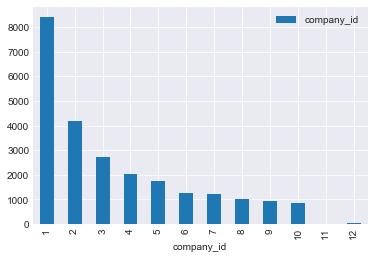

In [10]:
# plot the company_id and employees to see what's going on
employee_cleaned[['company_id']].groupby(employee_cleaned["company_id"]).count().plot(kind="bar")

# remove companies 11, 12 since they have virtually no employees
employee_cleaned = employee_cleaned[employee_cleaned['company_id']!=11]
employee_cleaned = employee_cleaned[employee_cleaned['company_id']!=12]

After excluding the startup-sized companies and focusing only on the employees that left their respective companies, we can look at the distribution of tenures (the total time spent at a company). 

It is apparent that the rate of employee attrition strongly depends on length of tenure - many employees quit after their first year of employement, while a second group quits around the second year mark. After two years the attrition rate is roughly steady but gradually decreases after around 4-5 years. 

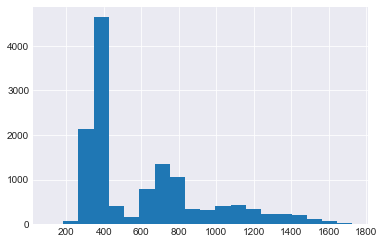

In [11]:
lifespan = employee_cleaned['quit_date'] - employee_cleaned['join_date']
divided = lifespan / pd.Timedelta(days=1)
divided.hist(bins=20)

### Kaplan-Meier curve

Of course, we know that there are many employees who do choose to stay in their current positions. A way to visualize employee attrition while still taking into account employees who never leave is via a Kaplan-Meier curve, which shows the fraction of employees who leave over time while also considering employees to never leave.

The K-M curve below largely reflects the number of leaving employees vs. time plot shown above. There is a large drop in employees near 1 year, another drop around 2 years, and then a gradual decline after. At the end of the test period approximately 40% of employees have never churned. 

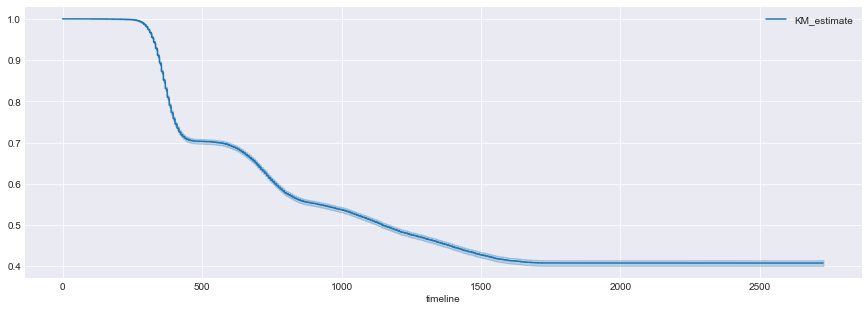

In [35]:
employee_cleaned = employee_cleaned.where(pd.notnull(employee_cleaned), None)
T, E = datetimes_to_durations(employee_cleaned['join_date'], employee_cleaned['quit_date'])

table = survival_table_from_events(T, E)

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succiently, kmf.fit(T, E)

kmf.survival_function_
kmf.median_
kmf.plot(figsize=(15,5))

### Dependence on company size, department

Ultimately we'd like to know if the employees who leave are different than the employees who don't. We can assign a value of 1 to employees who leave and a value of 0 to employees who stay with their current job. 

In [12]:
# define an attrition column (1 for attrtition)
employee_cleaned['turned_over'] = employee_cleaned['quit_date'] - employee_cleaned['join_date']

def cast_turned_over(entry):
    if entry > pd.to_timedelta('1 day'):
        return 1.0
    else:
        return 0.0

employee_cleaned['turned_over'] = employee_cleaned['turned_over'].apply(cast_turned_over)

As a quick check, we can see if there is evidence for a strong trend between company size and overall attrition rate (defined as the fraction of employees who stay in their current positions). 

There is essentially no difference in attrition rate as a function of company size - we can rule out company size as being a strong driver of employee churn. It may be worth revisiting this in the future to see if there is a time-dependent attrition rate that depends on company size (e.g., employees leaving a smaller company sooner due to better offers as they gain more experience). 

In [32]:
# plot attrition rate as a function of company size
company_attrate = employee_cleaned[['company_id','turned_over']].groupby('company_id')['turned_over'].mean()
print(company_attrate)

company_id
1     0.544903
2     0.521770
3     0.557636
4     0.559256
5     0.560920
6     0.550940
7     0.564930
8     0.550388
9     0.549266
10    0.554779
Name: turned_over, dtype: float64


We might also suspect that an employee's department may also influence churn. Similar to above, we can look at the attrition rate as a function of department. 

We see here that there are some minor differences on the order of a few percent, but again no major indications that department influences churn rate. 

In [33]:
dept_size = employee_cleaned[['dept','turned_over']].groupby('dept')['turned_over'].count()
dept_turnover = employee_cleaned[['dept','turned_over']].groupby('dept')['turned_over'].mean()
print(dept_turnover)

dept
customer_service    0.554784
data_science        0.526500
design              0.563690
engineer            0.511628
marketing           0.563439
sales               0.570884
Name: turned_over, dtype: float64


### Examining employee salaries

It seems intuitive that an employee's salary would directly influence their propensity to stay at a company. However, the different departments have different median salaries - an engineer gets paid much more than someone working in customer service. 

We can correct for these differences by computing the deviation of an employee's salary from their department median. The naive expectation we might have is that employees with negative deviations (i.e. employees who are making much less than the median for their department) would be more likely to leave their company. 

In [34]:
# median salary by department
dept_med_salary = employee_cleaned[['dept','salary', 'seniority']].groupby('dept')['salary'].median()
dept_med_salary

dept
customer_service     84000.0
data_science        209000.0
design              139000.0
engineer            209000.0
marketing           138000.0
sales               137000.0
Name: salary, dtype: float64

In [19]:
# dictionary with median salary per discipline
salary_by_dept = {'design': 139000.0, 'engineer': 209000.0, 'marketing': 138000.0, 'customer_service': 84000.0,'data_science': 209000.0, 'sales': 137000.0}

In [20]:
# now the idea is we want to convert everyone's salary to a department normalized number of mads (positive or negative)
# and plot this by experience, and color code by whether the employee turned over or not. 

employee_cleaned['median_salary'] = employee_cleaned['dept'].map(salary_by_dept)

# now calculate the % deviations (but this isn't absolute)
employee_cleaned['mads'] = (employee_cleaned['salary'] - employee_cleaned['median_salary'])/employee_cleaned['median_salary']

We can add the deviations to our employee data table:

In [21]:
employee_cleaned.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,turned_over,median_salary,mads
1,388804.0,8,design,21,191000.0,2011-05-17,2012-03-16,1.0,139000.0,0.374101
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10,1.0,139000.0,-0.352518
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30,1.0,209000.0,0.425837
5,287530.0,5,marketing,20,180000.0,2014-06-30,NaT,0.0,138000.0,0.304348
6,561043.0,3,customer_service,18,119000.0,2012-07-02,2014-03-28,1.0,84000.0,0.416667


So we've calculated the salary deviations for each employee (from department median salary), and now we'd like to see how this might influence churn. 

Another variable important to consider is the seniority of the employee - we would expect more senior employees to have salaries well above the median salary, while more junior employees may have lower-than-median salaries. We can visualize this effect by plotting the average deviation as a function of seniority. Since we are interested in churn, we color code by turned over/stayed on status. 

In [22]:
# now plot mads vs seniority but first sift by turned over or not
turned_over = employee_cleaned[employee_cleaned['turned_over'] == 1.0]
stayed_put = employee_cleaned[employee_cleaned['turned_over'] == 0.0]

In [24]:
# let's try plotting deviation vs yrs
turned_over_mm = turned_over.groupby('seniority')['mads'].mean()
stayed_put_mm = stayed_put.groupby('seniority')['mads'].mean()

seniority_values = np.sort(turned_over['seniority'].unique())

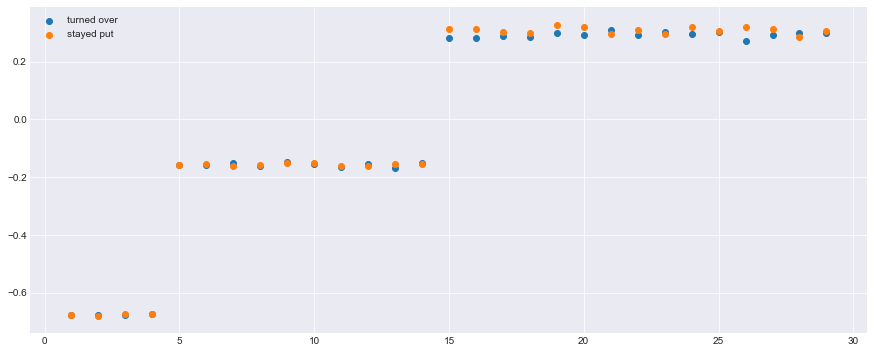

In [44]:
fig = plt.figure(figsize=(15, 6))
plt.scatter(seniority_values, turned_over_mm, label='turned over')
plt.scatter(seniority_values, stayed_put_mm, label='stayed put')
plt.legend(loc=2)

There's not much to see from the previous plot, other than the fact that all companies apparently practice "experience banding", where employees within a certain experience range all get comparable salaries. We would expect that maybe employees who are making less than the median department salary at a given experience level would be more likely to leave, but maybe this isn't the case. 

To try and investigate further, recall that many employees leave at the 1 or 2 year mark (in two distinct groups). Maybe these groups are different from one another? 

To investigate this possibility, we can bin our data by tenure into three groups: employees who leave before 500 days, those who leave between 500 and 1000 days, and those who leave after 1000 days. We can create a plot similar to that shown above, except exclude the employees who never left (that is, we only compare the three groups of employees who have left). 

In [26]:
# recall that a lot of people quit pretty early on, then some quit around 2 years
# and still others quit later. so let's bin the data coarsely - 3 bins of people: 0 to 500, 500 to 1000, and 1000+

one_year_turnover = turned_over[(turned_over['quit_date'] - turned_over['join_date']) < pd.to_timedelta('500 days')]

two_year_turnover = turned_over[(turned_over['quit_date'] - turned_over['join_date']) > pd.to_timedelta('500 days')]
two_year_turnover = two_year_turnover[(two_year_turnover['quit_date'] - two_year_turnover['join_date']) < pd.to_timedelta('1000 days')]

three_year_turnover = turned_over[(turned_over['quit_date'] - turned_over['join_date']) > pd.to_timedelta('1000 days')]

oneyear_mm = one_year_turnover.groupby('seniority')['mads'].mean()
twoyear_mm = two_year_turnover.groupby('seniority')['mads'].mean()
threeyear_mm = three_year_turnover.groupby('seniority')['mads'].mean()

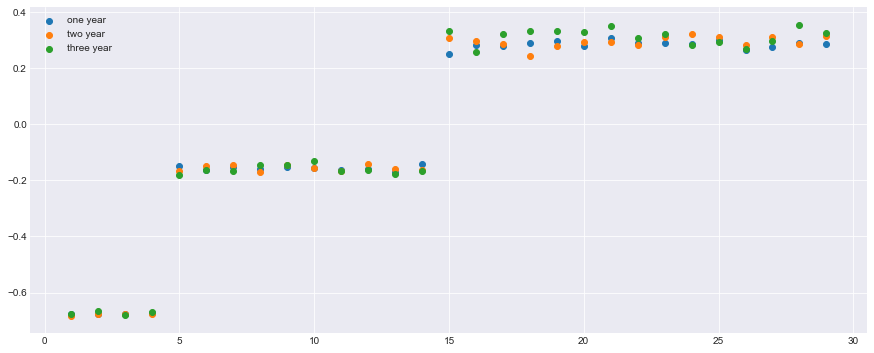

In [40]:
fig = plt.figure(figsize=(15,6))
plt.scatter(seniority_values, oneyear_mm, label='one year')
plt.scatter(seniority_values, twoyear_mm, label='two year')
plt.scatter(seniority_values, threeyear_mm, label='three year')
plt.legend(loc=2)

At this point, it seems safe to conclude that there's no "silver bullet" solution to employee churn hidden in the data being analyzed here. There just aren't strong indicators of churn to be found in employee salary and experience. 

### Feature correlations

As a final bit of analysis to confirm this, we can look for correlations between our features and the "deltas" of leaving employees, or the total time they spend in their jobs before leaving.

In the run-up to this, a few irregularities with the data we observed - looking at a plot of deviations vs deltas, there are strange gaps in the data which have no obvious explanation. It may be worth speaking with the people who collected the data to better understand the collection process. 

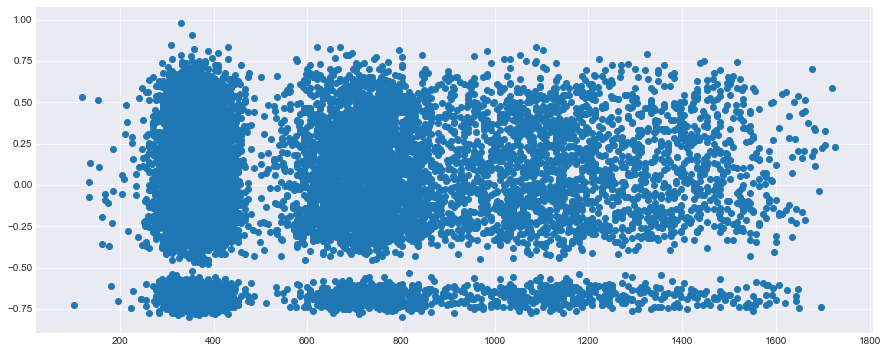

In [43]:
turned_over['delta'] = turned_over['quit_date']-turned_over['join_date']
turned_over['delta'] = turned_over['delta'].dt.days
fig = plt.figure(figsize=(15,6))
plt.scatter(turned_over['delta'], turned_over['mads'])

# that really is quite bizarre-looking data

The above irregularities notwithstanding, with the deltas computed, we can look for correlations between the various features and these deltas (since we are most interested in predicting when an employee will depart, the deltas are our "target" variable). 

It is immediately apparent that while features are correlated with each other (for example, seniority is correlated with salary deviation), nothing is particularly correlated with the delta variable, indicating that our suspicions are likely correct - there aren't any strong predictors of employee churn present in the data. 

([<matplotlib.axis.YTick at 0x112a388d0>,
 <a list of 4 Text yticklabel objects>)

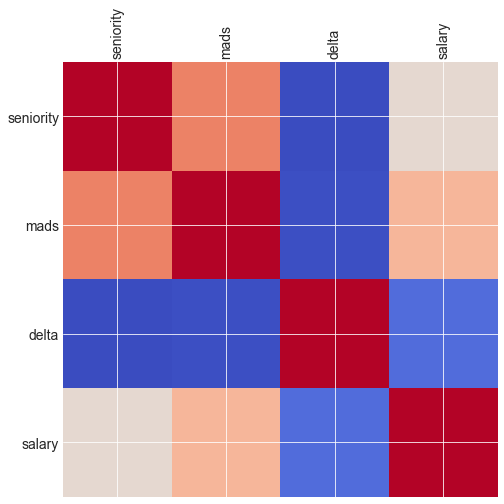

In [29]:
# try a correlation matrix
feature_correlations = turned_over[['seniority', 'mads', 'delta', 'salary']].corr()
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(feature_correlations,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(feature_correlations.columns)), feature_correlations.columns, rotation='vertical', fontsize=14)
plt.yticks(range(len(feature_correlations.columns)), feature_correlations.columns, fontsize=14)

# 3. Conclusion

The goal of this project was to predict employee churn, which is a costly and (ideally) avoidable event at many companies. To this end, a dataset consisting of employee salaries, departments, and seniority levels for several companies was analyzed to search for indicators of churn. 

During the course of the data exploration phase, several interesting insights were gathered:
1. While the companies had wildly different hiring rates, churn rate was approximately constant across the companies.
2. Churn rate was also largely constant with respect to department. 
3. Considering how long employees stay at a company before leaving, many employees leave after just one year of employment, another group tends to leave around the 2 year mark, and comparatively few employees leave after that. 
4. The deviations of salary level from department averages strongly depended on employee experience level. Counterintuitively, the salary deviations did not predict employee churn.
5. There are several patterns in the data that suggest problems with the data collection process - these problems could be masking correlations between the features analyzed and the likelyhood of employee churn. 

Ultimately, the features examined as part of this analysis do not predict employee churn likelyhood. Provided there were not major problems with the data collection process, this would seemingly indicate that employee churn is driven by other factors.

Intuitively, it does seem that there should be a connection between compensation and likelyhood of leaving. However, maybe base salary isn't necessarily a good predictor. In the future, it may be useful to have more information about an employee's compensation history - raises, bonuses, promotions, etc. as these may cause employees who would otherwise leave to stay with a company. 